In [6]:
import os
if not os.path.exists("/root/.kaggle/"):
    os.makedirs("/root/.kaggle/")
    with open("/root/.kaggle/kaggle.json", "w+") as f:
      # Write the text to the file
      f.write("""{"username":"isaacblach","key":
        "599d02c69c483f5ead7487a5b0bbae5b"}""")
!chmod 600 /root/.kaggle/kaggle.json
!pip install tensorflow-addons kaggle pandas matplotlib scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


# Project Goal and Overview
The goal of this project is to create a Generative Adversarial Network (GAN) to convert images into the monet style.  To do this, I will use the 300 monet images to perform the training.  There are 300 Monets

In [106]:
import kaggle
import zipfile
import tensorflow.keras as keras
from keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
import random
import math
import tensorflow_addons as tfa


from __future__ import absolute_import, division, print_function
import gzip, pickle
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

import requests
from os import getcwd
import tarfile

autotune = tf.data.AUTOTUNE
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
if not os.path.exists('kaggle'):
    !kaggle competitions download -c 'gan-getting-started'
    #!mkdir kaggle
    #!mkdir kaggle/input
    #!mkdir kaggle/input/gan-getting-started
    #!unzip -qq gan-getting-started.zip -d kaggle/input/gan-getting-started
    with zipfile.ZipFile('gan-getting-started.zip', 'r') as zip_ref:
        zip_ref.extractall(f"{input_dir}gan-getting-started")

100%|████████████████████████████████████████| 367M/367M [00:09<00:00, 49.6MB/s]
100%|████████████████████████████████████████| 367M/367M [00:09<00:00, 39.5MB/s]


# Data Description


In [121]:
tmp_dir = getcwd() + "/kaggle/tmp/"
input_dir = getcwd() + "/kaggle/input/"
if not os.path.exists(getcwd() + "/kaggle"):
    os.makedirs(getcwd() + "/kaggle")
if not os.path.exists(getcwd() + "/kaggle/tmp"):
    os.makedirs(getcwd() + "/kaggle/tmp")
if not os.path.exists(getcwd() + "/kaggle/tmp/images"):
    os.makedirs(getcwd() + "/kaggle/tmp/images")

In [9]:

def count_files_in_directory(directory_path):
    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if os.path.isfile(
        os.path.join(directory_path, f))]
    # Count the number of files
    file_count = len(files)
    return file_count
directory_path = f'{input_dir}gan-getting-started/monet_jpg'
file_count = count_files_in_directory(directory_path)
print(f'There are {file_count} Monet Images.')

directory_path = f'{input_dir}gan-getting-started/photo_jpg'
file_count = count_files_in_directory(directory_path)
print(f'There are {file_count} Photo Images.')

There are 300 Monet Images.
There are 7038 Photo Images.


20 Monet Images above 20 Photos


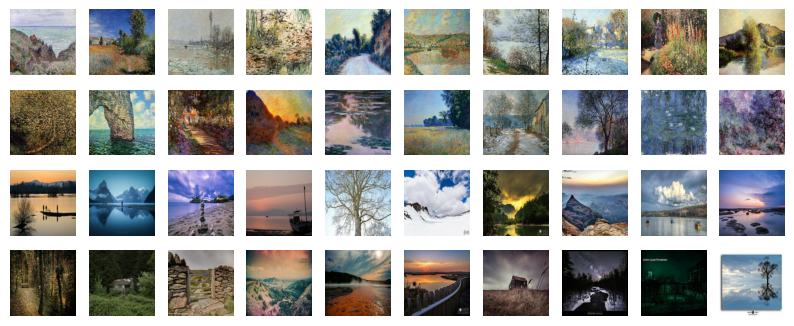

In [10]:
#Generated by Gemini AI but modified to actually work
# Get a list of all the files in the Monet directory
monet_files = os.listdir(f"{input_dir}gan-getting-started/monet_jpg")

# Get a list of all the files in the photo directory
photo_files = os.listdir(f"{input_dir}gan-getting-started/photo_jpg")

# Select 20 random Monet images
random_monet_files = random.sample(monet_files, 20)

# Select 20 random photo images
random_photo_files = random.sample(photo_files, 20)

# Create a 10x2 grid of subplots
fig, axes = plt.subplots(4, 10, figsize=(10, 4))
print("20 Monet Images above 20 Photos")

# Plot the Monet images in the first column

for i, filename in enumerate(random_monet_files):
    img = mpimg.imread(os.path.join(f"{input_dir}/gan-getting-started/monet_jpg", filename))
    axes[math.floor(i%2), math.floor(i/2)].imshow(img)
    axes[math.floor(i%2), math.floor(i/2)].axis('off')

## Plot the photo images in the second column
for i, filename in enumerate(random_photo_files):
    img = mpimg.imread(os.path.join(f"{input_dir}gan-getting-started/photo_jpg", filename))
    axes[math.floor(i%2+2), math.floor(i/2)].imshow(img)
    axes[math.floor(i%2+2), math.floor(i/2)].axis('off')

# Show the plot
plt.show()


# Data Loading and Batch Sizes
In order to perform faster data loading, I chose to load the tfrec files.  I seleted batch sizes to meet GPU memory limitations.

In [70]:
def count_elements(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count

def decode_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [256, 256])
  return image

def read_tfrecord(example):
  features = {
    'image': tf.io.FixedLenFeature([], tf.string),
  }
  example = tf.io.parse_single_example(example, features)
  image = decode_image(example['image'])
  return image
tfrecord_dir = f"{input_dir}gan-getting-started/monet_tfrec"
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(
    tfrecord_dir) if f.endswith('.tfrec')]
monet_images_dataset = tf.data.TFRecordDataset(
    tfrecord_files).map(read_tfrecord)

tfrecord_dir = f"{input_dir}gan-getting-started/photo_tfrec"
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(
    tfrecord_dir) if f.endswith('.tfrec')]
photo_images_dataset = tf.data.TFRecordDataset(
    tfrecord_files).map(read_tfrecord)
print(monet_images_dataset)



<_MapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>


In [71]:
# https://keras.io/examples/generative/cyclegan/
# Define the standard image size.
orig_img_size = (256, 256)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0
    #return (img / 127.5)
    #return (img)


def preprocess_train_image(img):
    # Random flip
    print(img)
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [77]:
img_size = 256
image_depth = 3
batch_size = 1
LR = 0.00012
buffer_size = 10000

In [79]:
# prompt: split TFRecordDataset into a train and test set 80/20 split


# Apply the preprocessing operations to the training data


monet_train_dataset = (
    monet_images_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Apply the preprocessing operations to the test data
photo_train_dataset = (
    photo_images_dataset.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'Photo Images Count {count_elements(photo_train_dataset)}')
print(f'Monet Images Count {count_elements(monet_train_dataset)}')

#for i, img in enumerate(monet_test_dataset.take(1)):
#    #print(f"Image {i}: {img}")
 #   plt.imshow(img[0] * 127.5 + 127.5)
 #   plt.title(f"Image {i}")
#    plt.axis('off')
#    plt.show()

Tensor("args_0:0", shape=(256, 256, 3), dtype=float32)
Photo Images Count 7038
Monet Images Count 300


#  Starting off the GAN
I used https://keras.io/examples/generative/cyclegan/ as a reference for the initial model build.

In [15]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [16]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


In [17]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")


/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [18]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adversarial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


In [19]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 25 != 0:
          return
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(photo_train_dataset.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = ((prediction * 127.5 + 127.5)*127.5).astype(np.int8)
            img = ((img[0]* 127.5 + 127.5)*127.5).numpy().astype(np.int8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.utils.array_to_img(prediction)
            prediction.save(
               "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()


Epoch 1/50


2024-06-01 22:09:48.237111: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-06-01 22:09:51.629146: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0f9800b5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-01 22:09:51.629205: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-06-01 22:09:51.636461: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717279791.786951    2959 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 [==============================] - 80s 704ms/step - G_loss: 14.2201 - F_loss: 14.1698 - D_X_loss: 0.3110 - D_Y_loss: 0.3103
Epoch 2/50
30/30 [==============================] - 20s 669ms/step - G_loss: 6.1675 - F_loss: 6.2207 - D_X_loss: 0.1986 - D_Y_loss: 0.1838
Epoch 3/50
30/30 [==============================] - 20s 661ms/step - G_loss: 1.7229 - F_loss: 1.8059 - D_X_loss: 0.2323 - D_Y_loss: 0.2326
Epoch 4/50
30/30 [==============================] - 20s 664ms/step - G_loss: 0.7833 - F_loss: 0.8277 - D_X_loss: 0.2386 - D_Y_loss: 0.2407
Epoch 5/50
30/30 [==============================] - 20s 659ms/step - G_loss: 0.5041 - F_loss: 0.5330 - D_X_loss: 0.2458 - D_Y_loss: 0.2466
Epoch 6/50
30/30 [==============================] - 20s 659ms/step - G_loss: 0.3880 - F_loss: 0.4111 - D_X_loss: 0.2475 - D_Y_loss: 0.2468
Epoch 7/50
30/30 [==============================] - 20s 657ms/step - G_loss: 0.3213 - F_loss: 0.3458 - D_X_loss: 0.2478 - D_Y_loss: 0.2489
Epoch 8/50
30/30 [==================

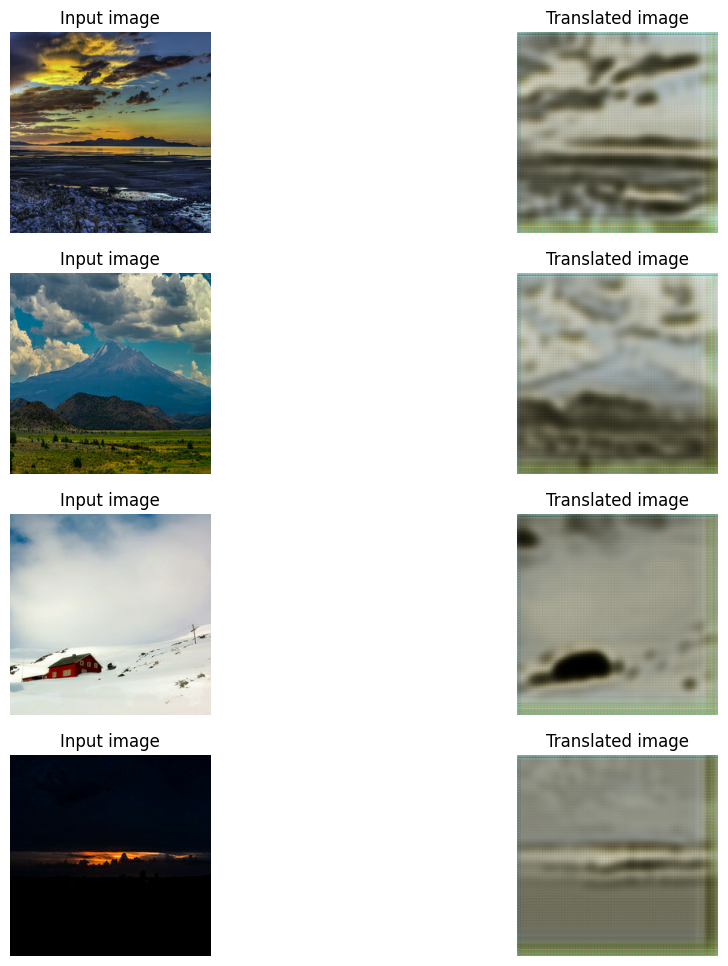

30/30 [==============================] - 23s 755ms/step - G_loss: 0.2665 - F_loss: 0.2755 - D_X_loss: 0.2486 - D_Y_loss: 0.2503
Epoch 26/50
30/30 [==============================] - 20s 656ms/step - G_loss: 0.2665 - F_loss: 0.2743 - D_X_loss: 0.2492 - D_Y_loss: 0.2502
Epoch 27/50
30/30 [==============================] - 20s 656ms/step - G_loss: 0.2668 - F_loss: 0.2763 - D_X_loss: 0.2496 - D_Y_loss: 0.2501
Epoch 28/50
30/30 [==============================] - 20s 653ms/step - G_loss: 0.2663 - F_loss: 0.2766 - D_X_loss: 0.2466 - D_Y_loss: 0.2501
Epoch 29/50
30/30 [==============================] - 20s 655ms/step - G_loss: 0.2662 - F_loss: 0.2748 - D_X_loss: 0.2487 - D_Y_loss: 0.2502
Epoch 30/50
30/30 [==============================] - 20s 655ms/step - G_loss: 0.2661 - F_loss: 0.2738 - D_X_loss: 0.2499 - D_Y_loss: 0.2502
Epoch 31/50
30/30 [==============================] - 20s 661ms/step - G_loss: 0.2657 - F_loss: 0.2714 - D_X_loss: 0.2497 - D_Y_loss: 0.2502
Epoch 32/50
30/30 [=============

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


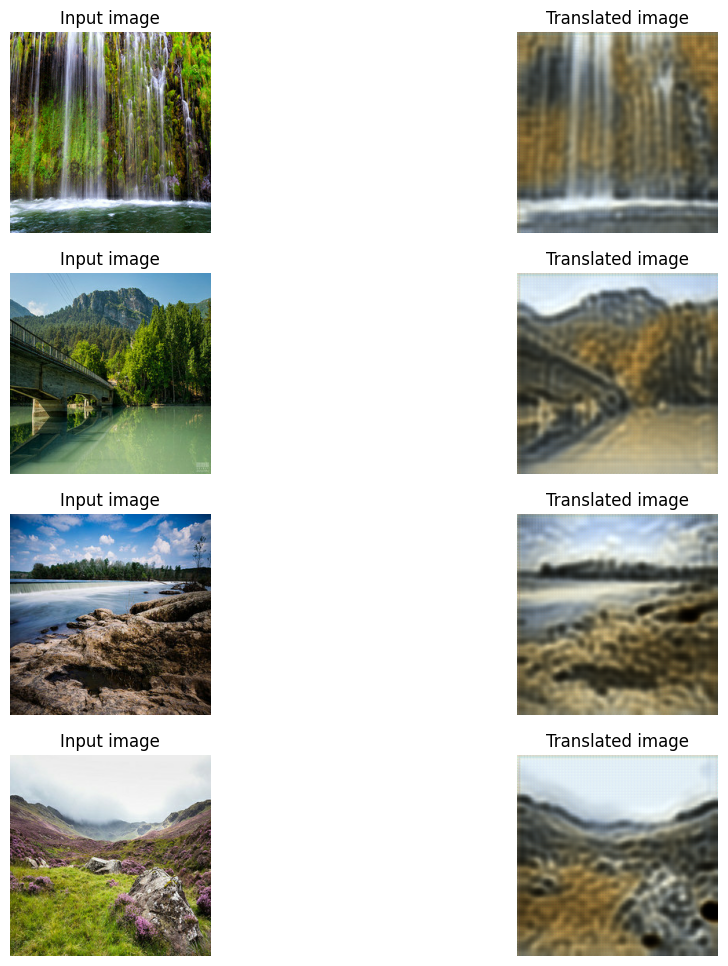

30/30 [==============================] - 21s 695ms/step - G_loss: 0.2633 - F_loss: 0.2668 - D_X_loss: 0.2498 - D_Y_loss: 0.2500


In [20]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return tf.reduce_mean(fake_loss)

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

# Assuming you have already defined your strategy

# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn
)

plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_train_dataset, monet_train_dataset)),
    epochs=50,
    callbacks=[plotter, model_checkpoint_callback],
)

# Good Start
The defaults are showing a good starting point.  I'll try to improve on this.  

In [21]:
#!curl -LO https://github.com/AakashKumarNain/CycleGAN_TF2/releases/download/v1.0/saved_checkpoints.zip
#!unzip -qq saved_checkpoints.zip


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


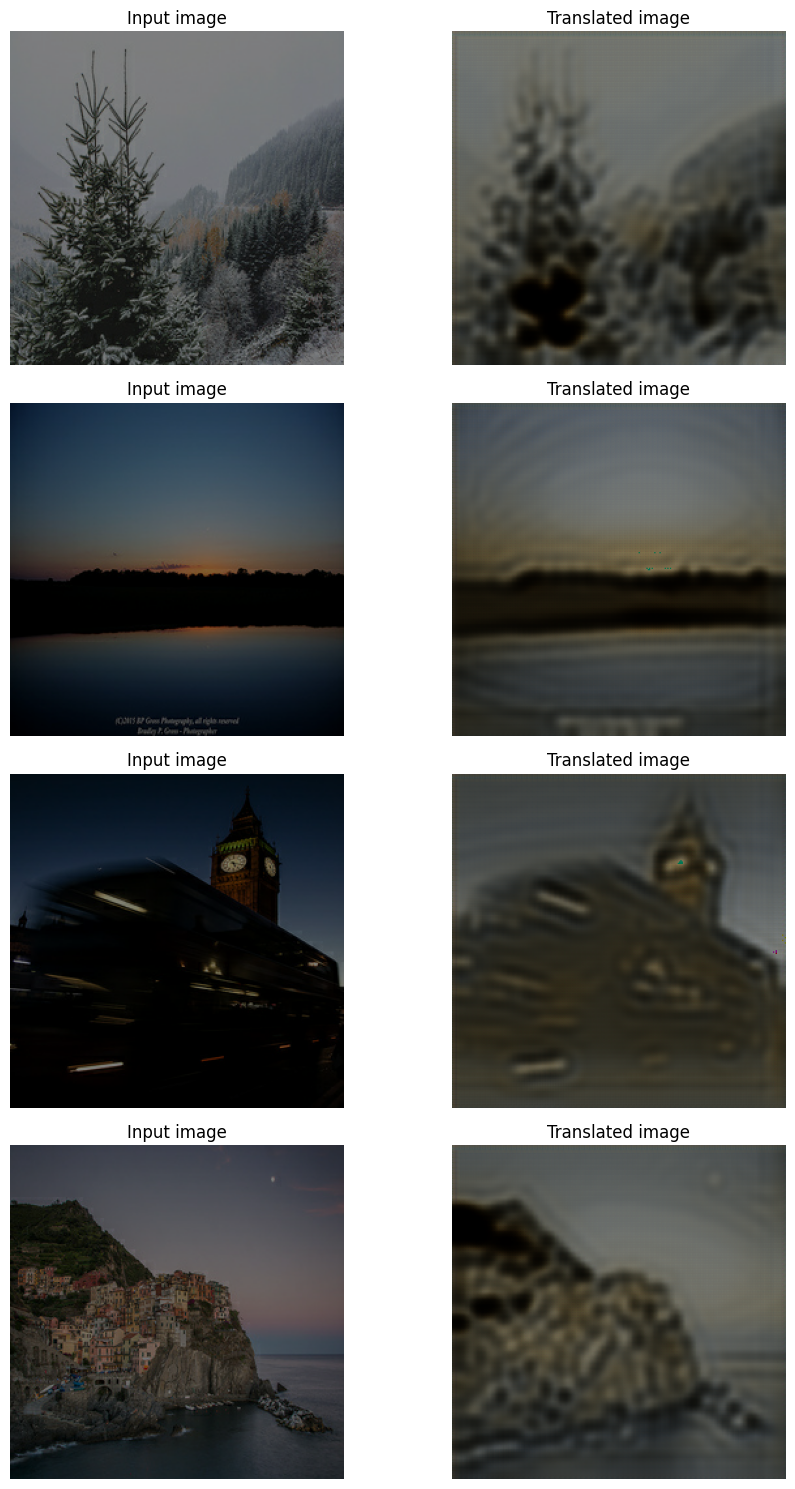

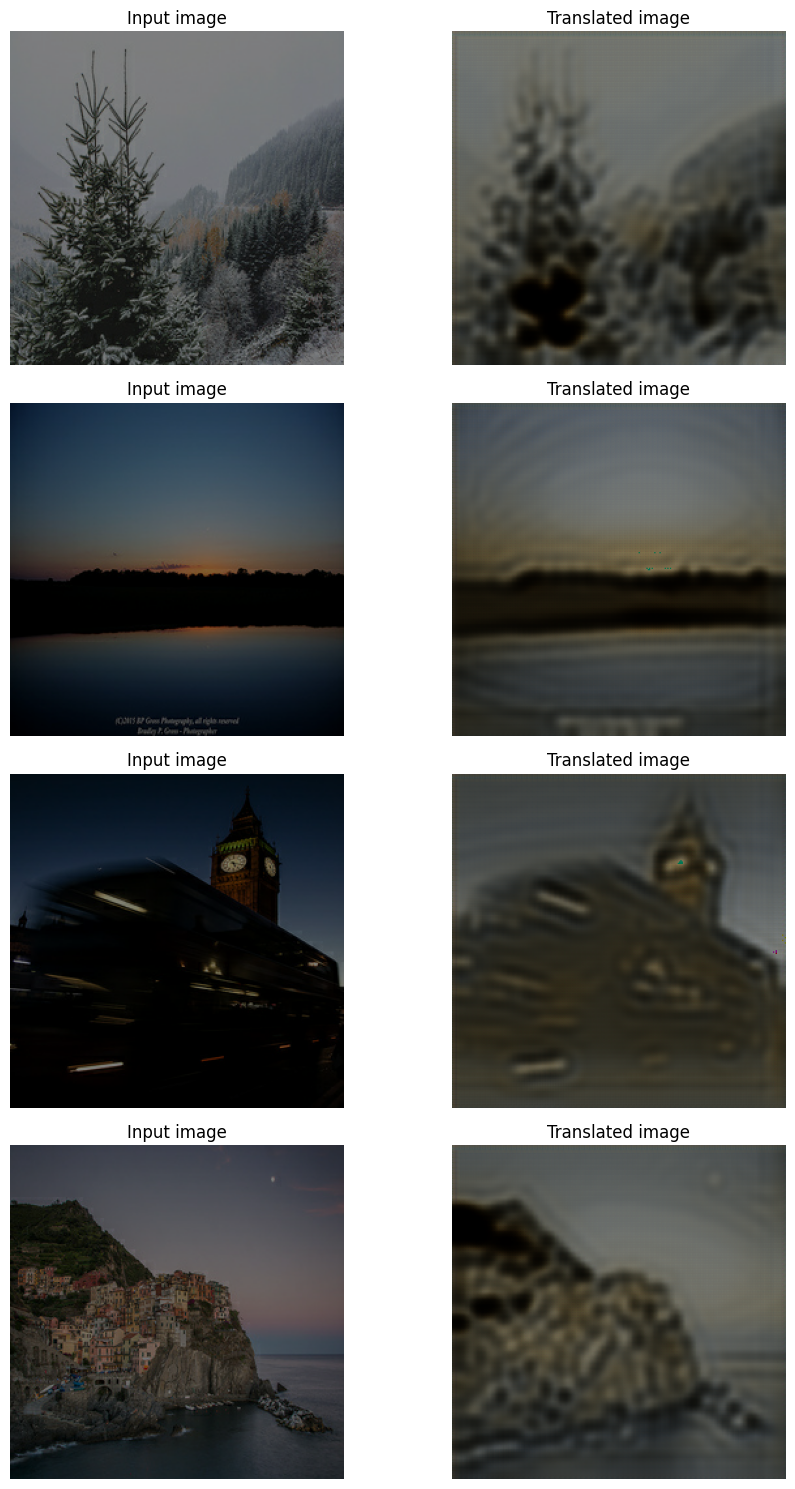

In [90]:
# Load the checkpoints
#weight_file = "./saved_checkpoints/cyclegan_checkpoints.090"
#cycle_gan_model.load_weights(weight_file).expect_partial()
#print("Weights loaded successfully")

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(photo_train_dataset.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = ((prediction * 127.5 + 127.5)*127.5).astype(np.int8)
    img = ((img[0]* 127.5 + 127.5)*127.5).numpy().astype(np.int8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.utils.array_to_img(prediction)
    #prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show(False)


In [128]:
def create_images():

    img_dir = f"{tmp_dir}/images/"
    #print(count_elements(photo_train_dataset))
    for i, img in enumerate(photo_train_dataset.take(256)):
        prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
        prediction = ((prediction * 127.5 + 127.5)*127.5).astype(np.uint8)  # Convert to uint8
        prediction = keras.utils.array_to_img(prediction)
        print(prediction.format)
        prediction.save(
            f"{tmp_dir}images/generated_img_{i}.png".format(i=i)
        )
        im = Image.open(str(f"{tmp_dir}images/generated_img_{i}.png".format(i=i)))
        print(im.format)
        #print(f"Saved {img_dir}predicted_img_{i}.png")
        break
    print(f"{i+1} Images saved")
create_images()

None
PNG
1 Images saved


# Scoring Code
Copied from Kaggle.  Updated by ChatGPT for TensorFlow 2.x compatability.

In [125]:
# Modded by chatgpt to eliminate tensorflow 1.x compatability issues.

import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
import warnings
from scipy import linalg
import pathlib

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 256,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.io.gfile.GFile(pth, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='Pretrained_Net')

def _get_model_layer(graph, model_name):
    layername = model_params[model_name]['output_layer']
    layer = graph.get_tensor_by_name(layername)
    return layer

def get_activations(images, graph, model_name, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- graph       : current graph
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(graph, model_name)
    input_layer = graph.get_tensor_by_name(model_params[model_name]['input_layer'])

    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images // batch_size + 1
    pred_arr = np.empty((n_images, model_params[model_name]['output_shape']))
    
    with tf.compat.v1.Session(graph=graph) as sess:
        for i in tqdm(range(n_batches)):
            if verbose:
                print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
            start = i * batch_size
            if start + batch_size < n_images:
                end = start + batch_size
            else:
                end = n_images
                    
            batch = images[start:end]
            pred = sess.run(inception_layer, {input_layer: batch})
            pred_arr[start:end] = pred.reshape(-1, model_params[model_name]['output_shape'])
        if verbose:
            print(" done")
    
    return pred_arr

def normalize_rows(x: np.ndarray):
    """
    Function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x / np.linalg.norm(x, ord=2, axis=1, keepdims=True))

def cosine_distance(features1, features2):
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0 - np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=', d.shape)
    print('np.min(d, axis=1).shape=', np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=', mean_min_d)
    return mean_min_d

def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    print('covmean.shape=', covmean.shape)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def calculate_activation_statistics(images, graph, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- graph       : current graph
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, graph, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act

def _handle_path_memorization(path, graph, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, graph, model_name)
    del x #clean up memory
    return m, s, features

def img_read_checks(filename, resize_to, is_checksize=False, check_imsize=256, is_check_png=False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize, check_imsize):
        raise KernelEvalException('The images are not of size ' + str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to, resize_to), Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None):
    """Calculates the KID of two paths."""
    graph = tf.Graph()
    with graph.as_default():
        create_model_graph(model_path)

    m1, s1, features1 = _handle_path_memorization(paths[0], graph, model_name, is_checksize=True, is_check_png=True)
    if feature_path is None:
        m2, s2, features2 = _handle_path_memorization(paths[1], graph, model_name, is_checksize=False, is_check_png=False)
    else:
        with np.load(feature_path) as f:
            m2, s2, features2 = f['m'], f['s'], f['features']

    print('m1, m2 shape=', (m1.shape, m2.shape), 's1, s2=', (s1.shape, s2.shape))
    print('starting calculating FID')
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)
    print('done with FID, starting distance calculation')
    distance = cosine_distance(features1, features2)
    return fid_value, distance




In [126]:
if not os.path.exists("kaggle/tmp/classify_image_graph_def.pb"):
    url = "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz"
    filename = tmp_dir + 'inception-2015-12-05.tgz'
    r = requests.get(url)
    with open(filename, 'wb') as output:
        output.write(r.content)
    tgz_file_path = directory + 'inception-2015-12-05.tgz'
    # Directory where you want to extract the contents
    extract_dir = directory

    # Open the .tgz file
with tarfile.open(tgz_file_path, 'r:gz') as tar:
    # Extract all the contents
    tar.extractall(path=extract_dir)
    
user_images_unzipped_path = f'{input_dir}gan-getting-started/monet_jpg/'
images_path = [user_images_unzipped_path, f'{tmp_dir}images/']

public_path = f'{tmp_dir}classify_image_graph_def.pb'

fid_epsilon = 10e-15

fid_value_public, distance_public = calculate_kid_given_paths(images_path, 'Inception', public_path)
distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ", fid_value_public / (distance_public + fid_epsilon))

KernelEvalException: Only PNG images should be submitted.

In [96]:
!git add .
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"
!git commit -m "no"
!git push

[main c88b5a6] no
 3 files changed, 322 insertions(+), 118 deletions(-)
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 255 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 3.54 MiB | 7.60 MiB/s, done.
Total 6 (delta 3), reused 1 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To github.com:isaac1987a/Something_of_a_Painter_Myself.git
   3ceaa55..c88b5a6  main -> main
